# Выбор локации для скважины

Нужно построить модель машинного обучения, которая поможет ответить на вопрос: "Где бурить новую скважину?", основываясь на данных о качестве и количестве нефти в 3-ех регионах.
В каждом регионе по 10 000 месторождений. Возможную прибыль и риски нужно проанализировать техникой *Bootstrap*.

По условию задачи необходимо использовать LinearRegression для предсказания объемов сырья.
Выбрать нужно только регионы с вероятностью убытков <2.5%.
Известен бюджет на разработку скважины в регионе, стоимость единицы сырья, с помощью чего можно посчитать прибыльность скважины. 

Метрики: RMSE, R2

### План работы
1. [Загрузка и подготовка данных](#1.-Загрузка-и-подготовка-данных)
2. [Обучение и проверка модели](#2.-Обучение-и-проверка-модели)
3. [Подготовка к расчёту прибыли](#3.-Подготовка-к-расчёту-прибыли)
4. [Расчёт прибыли и рисков ](#4.-Расчёт-прибыли-и-рисков)
5. [Общий вывод.](#5.-Общий-вывод)



### Описание данных  
Фичи: 3 значимых признака скважины, целевой признак - объем запасов нефти в скважине.




# 1. Загрузка и подготовка данных

In [1]:
#импортирование нужных библиотек:
import pandas as pd
import numpy as np
from scipy import stats as st
from numpy.random import RandomState
state = RandomState(12345) 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#визуализация
import seaborn as sns
import matplotlib.pyplot as plt
import itertools


#игнорирование предупреждений
import warnings
warnings.filterwarnings("ignore")

In [2]:
data1 = pd.read_csv('datasets/geo_data_0.csv') 
data2 = pd.read_csv('datasets/geo_data_1.csv')
data3 = pd.read_csv('datasets/geo_data_2.csv')

Сохраним имена датабаз для удобства:

In [3]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name  
data1.name = get_df_name(data1)
data2.name = get_df_name(data2)
data3.name = get_df_name(data3)

Изучим данные:

In [4]:
def examine_df(df):
    print(f'Данные {df.name}')
    display(df.head(10))
    display(df.info())
    display(df.describe())
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data.style.format('{:.1f}', subset='Percent')
    
    print(f'Количество пропусков {missing_data}')    
    print(f'Количество дубликатов : {df.duplicated().sum()}')
    print('_____________________________________________')

In [5]:
examine_df(data1)    
examine_df(data2)
examine_df(data3)

Данные data1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Количество пропусков          Total  Percent
product      0      0.0
f2           0      0.0
f1           0      0.0
f0           0      0.0
id           0      0.0
Количество дубликатов : 0
_____________________________________________
Данные data2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Количество пропусков          Total  Percent
product      0      0.0
f2           0      0.0
f1           0      0.0
f0           0      0.0
id           0      0.0
Количество дубликатов : 0
_____________________________________________
Данные data3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Количество пропусков          Total  Percent
product      0      0.0
f2           0      0.0
f1           0      0.0
f0           0      0.0
id           0      0.0
Количество дубликатов : 0
_____________________________________________


In [6]:
def visualize_df(df):
    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(16, 3))    
    fig.suptitle(f'Данные {df.name}')
    palette = itertools.cycle(sns.color_palette())
    for col, ax in zip(['f0','f1', 'f2', 'product'], axes.flat):
        color = next(palette)
        axes[0].set_ylabel('frequency')
        sns.distplot(df[col], color=color, ax=ax)
        fig.show()

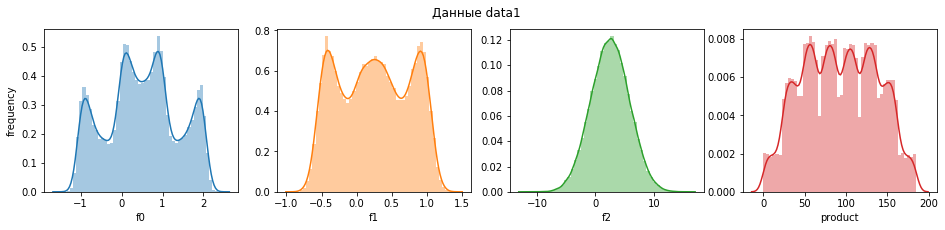

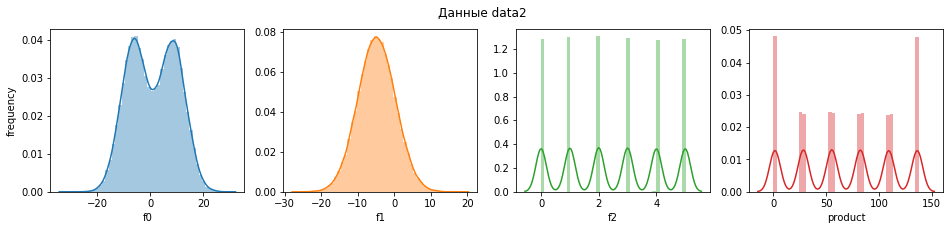

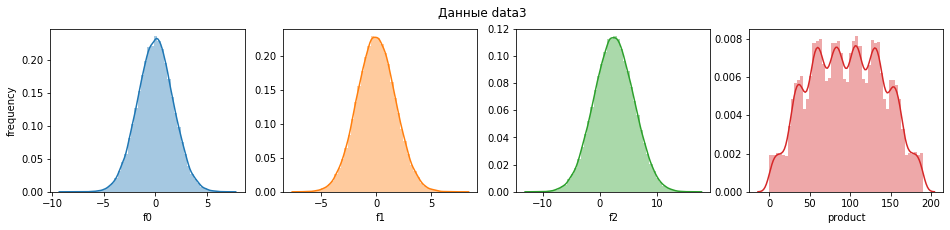

In [7]:
visualize_df(data1)
visualize_df(data2)
visualize_df(data3)

### Вывод
Данные без пропусков и дупликатов, предобработка не требуется. Для обучения модели избавимся от признака `id`, он не несет никакой нужной нам информации.

# 2. Обучение и проверка модели

Разобъем данные на обучающую и валидационную выборки в соотношении 3:1, отмасштабируем признаки.

In [8]:
def split_data(df):
    print(f'Данные {df.name}')
    features = df.drop(['id', 'product'], axis=1)
    target = df['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=state)
    print(features_train.shape)
    print(features_valid.shape)
    scaler = StandardScaler()
    scaler.fit(features_train[['f0','f1','f2']])
    features_train[['f0','f1','f2']] = scaler.transform(features_train[['f0','f1','f2']])
    features_valid[['f0','f1','f2']] = scaler.transform(features_valid[['f0','f1','f2']])
    return features, target, features_train, target_train, features_valid, target_valid


features1, target1, features_train1, target_train1, features_valid1, target_valid1 = split_data(data1)
features2, target2, features_train2, target_train2, features_valid2, target_valid2 = split_data(data2)
features3, target3, features_train3, target_train3, features_valid3, target_valid3 = split_data(data3)

Данные data1
(75000, 3)
(25000, 3)
Данные data2
(75000, 3)
(25000, 3)
Данные data3
(75000, 3)
(25000, 3)


In [9]:
features_train1.head()

,f0,f1,f2
27212,-0.544828,1.390264,-0.094959
7866,1.455912,-0.480422,1.209567
62041,0.260460,0.825069,-0.204865
70185,-1.837105,0.010321,-0.147634
82230,-1.299243,0.987558,1.273181


Напишем функцию для обучения Линейной регрессии для разных регионов:

In [10]:
def regression(features_train, target_train, features_valid, target_valid):
    model = LinearRegression() 
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predicted_valid)
    rmse = mse ** 0.5
    r2 = r2_score(target_valid, predicted_valid)
    print("Linear Regression")
    print("MSE =", mse)
    print("RMSE =", rmse)
    print("r2 =", r2)
    valid = pd.DataFrame({'target_valid': target_valid, 'predicted_valid':predicted_valid})
    print(valid.head(10))
    predicted_mean = predicted_valid.mean()
    print('Средний запас предсказанного для валидационной выборки сырья', predicted_mean)
    print('Средний запас сырья валидационной выборки', target_valid.mean(), '\n')
    return mse, rmse, r2, valid, predicted_mean 
print('1 регион')
mse1, rmse1, r2_1, valid1, predicted_mean1  = regression(features_train1, target_train1, features_valid1, target_valid1)
print('2 регион')
mse2, rmse2, r2_2, valid2, predicted_mean2 = regression(features_train2, target_train2, features_valid2, target_valid2)
print('3 регион')
mse3, rmse3, r2_3, valid3, predicted_mean3 = regression(features_train3, target_train3, features_valid3, target_valid3)





1 регион
Linear Regression
MSE = 1412.2129364399243
RMSE = 37.5794217150813
r2 = 0.27994321524487786
       target_valid  predicted_valid
71751     10.038645        95.894952
80493    114.551489        77.572583
2655     132.603635        77.892640
53233    169.072125        90.175134
91141    122.325180        70.510088
9539      37.735331        69.127076
8482     139.227191       125.106759
30284     72.491987        87.643849
66393     11.465993        86.035871
99584    110.562031        98.655311
Средний запас предсказанного для валидационной выборки сырья 92.59256778438038
Средний запас сырья валидационной выборки 92.07859674082927 

2 регион
Linear Regression
MSE = 0.7916315265952032
RMSE = 0.889736773768064
r2 = 0.9996264922748638
       target_valid  predicted_valid
70156     53.906522        54.238152
42796     84.038886        83.217878
36723      3.179103         2.971467
79446     26.953261        25.916480
93328    110.992147       111.341137
83694     30.132364        2

### Вывод
Модель линейной регрессии лучше всего сработала на данных второго региона, коэффициент детерминации почти единица. Запас предсказанного сырья меньше во втором регионе, по сравнению с первым и третьим.

# 3. Подготовка к расчёту прибыли

Сохраним все нужные числа для расчетов в константы и расчитаем, сколько минимально нужно сырья для неубыточности скважины:

In [11]:
BUDGET = 10000000000
CANDIDATES = 500
BEST_CANDIDATES = 200
PRICE_PER_HUNDRED = 450000
ONE_CANDIDATE_BUDGET = BUDGET / BEST_CANDIDATES
THRESHOLD_PRODUCT = ONE_CANDIDATE_BUDGET / PRICE_PER_HUNDRED
print('Достаточный объём сырья для безубыточной разработки новой скважины', THRESHOLD_PRODUCT)



Достаточный объём сырья для безубыточной разработки новой скважины 111.11111111111111


### Вывод
Получается, что в среднем скважины убыточны. Но нам предстоит еще выбрать лучших.

# 4. Расчёт прибыли и рисков 

Выберем 200 скважин из каждого региона с наибольшими предсказанными значениями количества сырья и посчитаем прибыль:

In [12]:
def profit(data):
    data = data.sort_values(by='predicted_valid', ascending=False)[:BEST_CANDIDATES]
    product_sum = data['target_valid'].sum()
    revenue = product_sum * PRICE_PER_HUNDRED
    profit = revenue - BUDGET
    return profit

profit1 = profit(valid1)
print('Прибыль с 200 лучших скважин из валидационной выборки 1го региона', profit1)

profit2 = profit(valid2)
print('Прибыль с 200 лучших скважин из валидационной выборки 2го региона', profit2)

profit3 = profit(valid3)
print('Прибыль с 200 лучших скважин из валидационной выборки 3го региона', profit3)

Прибыль с 200 лучших скважин из валидационной выборки 1го региона 3320826043.1398525
Прибыль с 200 лучших скважин из валидационной выборки 2го региона 2415086696.681511
Прибыль с 200 лучших скважин из валидационной выборки 3го региона 2539915945.842947


Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли, посчитаем оценки рисков:

In [13]:
def profit_bootstrap(data):
    values = []
    loss = 0
    for i in range(1000):
        subsample = data.sample(n=500, random_state=state, replace=True)
        prof = profit(subsample)
        values.append(prof)
        if prof < 0:
            loss+=1
    
    values = pd.Series(values)
    mean = values.mean()
    low = values.quantile(0.025)
    up = values.quantile(0.975)
    losses = loss/10
    return low, up, mean, losses

def print_bootstrap_results(low, up, mean, losses):
    print(f"95%-ый доверительный интервал: {low,up}")
    print("Средняя выручка:", mean) 
    print(f'Доля убытков {losses}%')

In [14]:
low1, up1, mean1, losses1 = profit_bootstrap(valid1)
print_bootstrap_results(low1, up1, mean1, losses1)

95%-ый доверительный интервал: (-69450566.85672115, 915496165.8311511)
Средняя выручка: 394284411.34055066
Доля убытков 6.1%


In [15]:
low2, up2, mean2, losses2 = profit_bootstrap(valid2)
print_bootstrap_results(low2, up2, mean2, losses2)

95%-ый доверительный интервал: (61071811.297698975, 855914149.1428356)
Средняя выручка: 454736359.09735787
Доля убытков 0.7%


In [16]:
low3, up3, mean3, losses3 = profit_bootstrap(valid3)
print_bootstrap_results(low3, up3, mean3, losses3)

95%-ый доверительный интервал: (-162650946.9422927, 847761844.5147681)
Средняя выручка: 353664097.5248346
Доля убытков 7.6%


# 5. Общий вывод
Для разработки скважин следует выбрать регион номер 2. Он обещает наибольшую среднюю выручку, вероятность убытков всего 1%, что меньше 2.5%, указанных в условии.